In [10]:
import os
import pandas
import pickle
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Config
PLOT_ON = False
LOAD_PARTIAL = True
REF_DIR = "in"
MEDIA_DIR = "out"
MODEL_NAME = "model4"
PIPELINE_NAME = "pipeline4.pkl"

#Load up the test data from the Pickle file
def load_data(b_load_partial_data):
    if not b_load_partial_data:
        DATA_NAME = "Xtrain.pkl"
        LABEL_NAME = "Ytrain.pkl"
        data_path = os.path.join(REF_DIR, DATA_NAME)
        with open(data_path, "rb") as data_in:
            data_X = pandas.read_pickle(data_in)
        label_path = os.path.join(REF_DIR, LABEL_NAME)
        with open(label_path, "rb") as data_in:
            data_Y = pandas.read_pickle(data_in)
    else:
        for i in range(2):
            data_name = "project4cleanset_0"+str(i+1)+".pkl"
            data_path = os.path.join(REF_DIR, data_name)
            if i == 0:
                with open(data_path, "rb") as data_in:
                    data_Y = pandas.read_pickle(data_in)
            else:
                with open(data_path, "rb") as data_in:
                    data_Y = np.concatenate((data_Y, pandas.read_pickle(data_in)))
        for i in range(2):
            data_name = "project4noiseset_0"+str(i+1)+".pkl"
            data_path = os.path.join(REF_DIR, data_name)
            if i == 0:
                with open(data_path, "rb") as data_in:
                    data_X = pandas.read_pickle(data_in)
            else:
                with open(data_path, "rb") as data_in:
                    data_X = np.concatenate((data_X, pandas.read_pickle(data_in)))
    return [data_X, data_Y]

[data_features, data_clean] = load_data(LOAD_PARTIAL)
print(data_features.size)

47040000


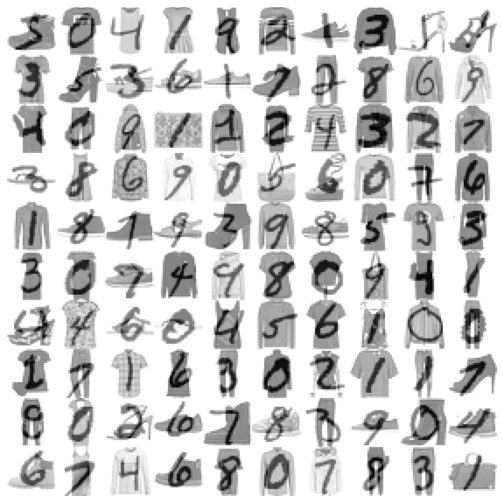

In [11]:
#Geta  feel for data.
import matplotlib.pyplot as plt
import matplotlib
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instances[i:i+1].reshape(size,size) for i in range(instances.shape[0])]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
#%%
plt.figure(figsize=(9,9))
example_images = data_features[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

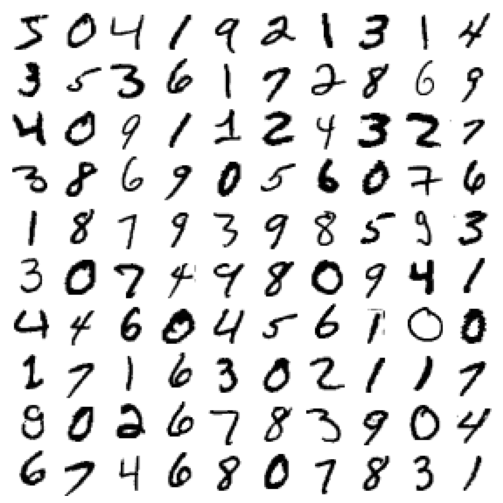

In [12]:
plt.figure(figsize=(9,9))
example_images = data_clean[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [19]:
from tensorflow import keras
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.5))
print(stacked_ae.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_16 (Sequential)   (None, 1, 28, 28)         82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
history = stacked_ae.fit(data_features, data_clean, epochs=5)#,
    # validation_data=[data_clean])
codings = stacked_ae.predict(data_features)

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2684
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2637
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2635
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2634
Epoch 5/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2634


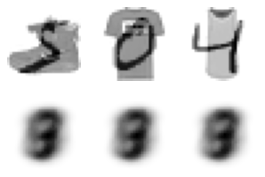

In [103]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=3):
    reconstructions = model.predict(data_features[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(data_features[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index].reshape([28,28]))

show_reconstructions(stacked_ae)

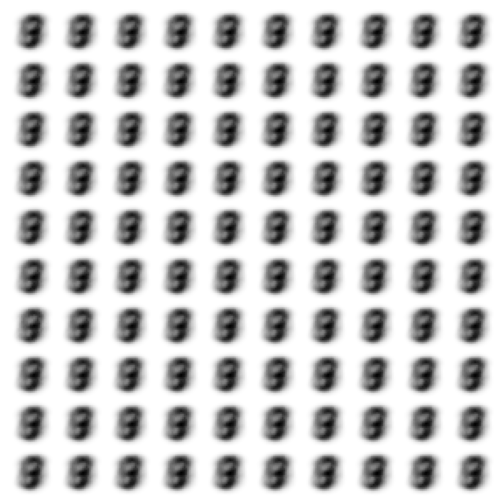

In [41]:
plt.figure(figsize=(9,9))
example_images = codings[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [115]:
# #Trying it with CNN
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(8, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    # keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    # keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(16, kernel_size=2, strides=2,
        padding="valid",
        activation="selu",
        input_shape=[7, 7, 16]),
    # keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding="same",
    #     activation="selu"),# input_shape=[7, 7, 32],),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
        activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.5))

print(conv_encoder.summary())
print(conv_decoder.summary())
print(conv_ae.summary())

Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_85 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 7, 7, 16)          0         
Total params: 1,248
Trainable params: 1,248
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_129"
_________________________________________________________________
Layer (type)         

In [119]:
history = conv_ae.fit(data_features, data_features, epochs=20,
    validation_data=[data_clean])
codings = conv_ae.predict(data_features)

Epoch 1/10
1875/1875 [==============================] - 20s 11ms/step - loss: -0.5778 - val_loss: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: -0.5780 - val_loss: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: -0.5790 - val_loss: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: -0.5797 - val_loss: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 19s 10ms/step - loss: -0.5798 - val_loss: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: -0.5808 - val_loss: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: -0.5813 - val_loss: 0.0000e+00
Epoch 8/10
1875/1875 [==============================] - 19s 10ms/step - loss: -0.5814 - val_loss: 0.0000e+00
Epoch 9/10
1875/1875 [==============================] - 19s 10ms/step - loss: -0.5821 - val_loss: 0.0000e+00
Epoch 10/10
1875/18

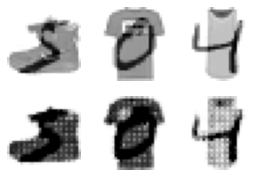

In [120]:
show_reconstructions(conv_ae)

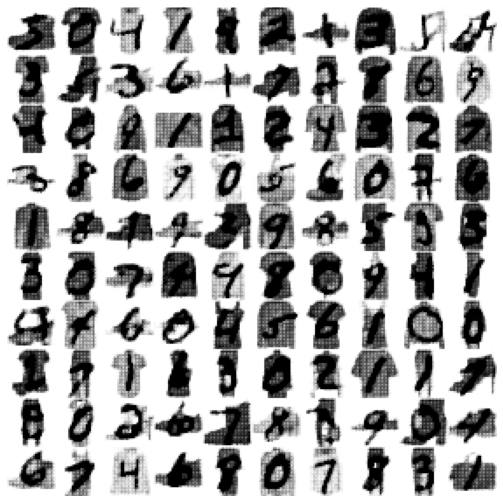

In [121]:
plt.figure(figsize=(9,9))
example_images = codings[:100]
plot_digits(example_images, images_per_row=10)
plt.show()